In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tools.eval_measures import rmspe
from sklearn.model_selection import TimeSeriesSplit
import keras
from tensorflow.keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score



In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


1.	Isolate the Rossmann Store Sales dataset into time series data

In [3]:
df_train = pd.read_csv(r'C:\Users\Niti\NEXT HIKES\PROJECT 6\df_train_for_deeplearning.csv', index_col='Date', parse_dates=True)
df_test = pd.read_csv(r'C:\Users\Niti\NEXT HIKES\PROJECT 6\df_test_for_deeplearning.csv', index_col='Date', parse_dates=True)

In [4]:
df_train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Month,Year,Distance_to_Competitor,Weekdays,Weekends,Days_to_Holiday,Days_after_Holiday,Beginning_of_month,Mid_month,End_of_month
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0.0,1,2.0,0.0,...,7,2015,1270.0,4,0,0,0.0,0,0,1
2015-07-31,2,5,6064,625,1,1,0.0,1,0.0,0.0,...,7,2015,570.0,4,0,0,0.0,0,0,1


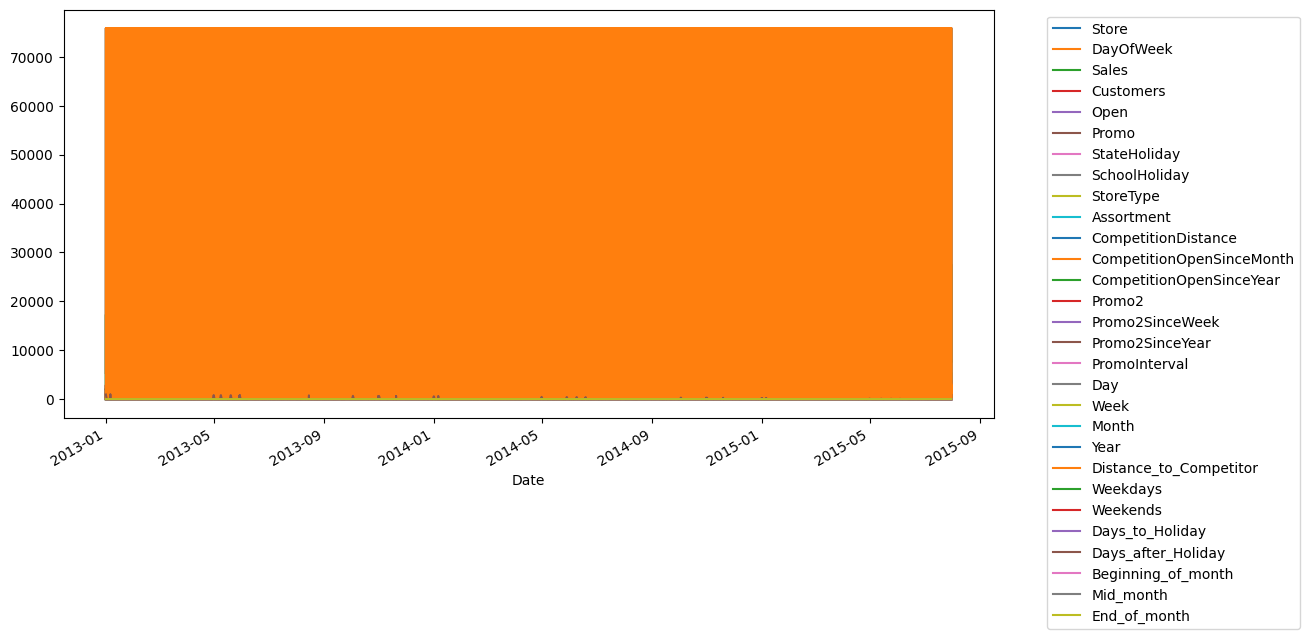

In [5]:
df_train.plot(figsize=(12,6))
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

2.	Check whether your time Series Data is Stationary

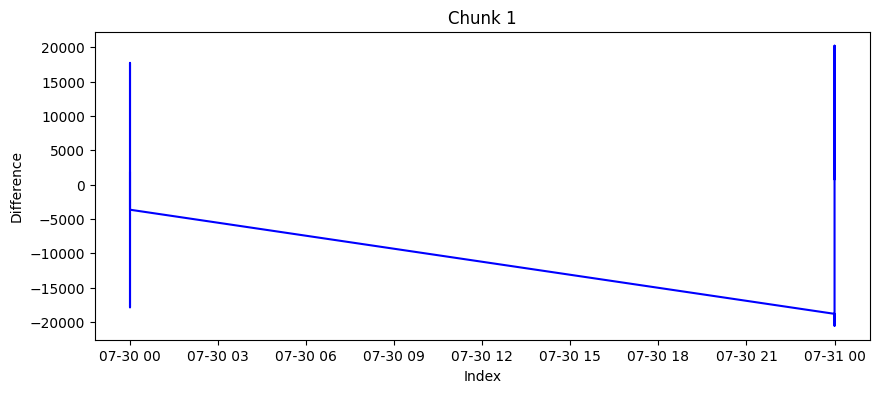

Chunk 1
ADF statistics:  -15.454115638809549
p-values: 2.7596216659777057e-28
Critical Values:  {'1%': -3.433665351698571, '5%': -2.8630045337025267, '10%': -2.567549656849864}
Reject the null hypothesis - Data is stationary
Chunk 2 contains only constant values.
Chunk 3 contains only constant values.
Chunk 4 contains only constant values.
Chunk 5 contains only constant values.
Chunk 6 contains only constant values.
Chunk 7 contains only constant values.
Chunk 8 contains only constant values.
Chunk 9 contains only constant values.
Chunk 10 contains only constant values.
Chunk 11 contains only constant values.
Chunk 12 contains only constant values.
Chunk 13 contains only constant values.
Chunk 14 contains only constant values.
Chunk 15 contains only constant values.
Chunk 16 contains only constant values.
Chunk 17 contains only constant values.
Chunk 18 contains only constant values.
Chunk 19 contains only constant values.
Chunk 20 contains only constant values.
Chunk 21 contains only 

In [6]:
# check for the statinarity of the data
def test_stationarity(timeseries, chunk_size = 2000):
  n = len(timeseries)
  
  # Perform the dicky fuller test
  for i in range(0,n, chunk_size):
    chunk = timeseries.iloc[i:min(1 + chunk_size, n)]
    chunk_diff = chunk.diff().fillna(0)
    chunk_diff_nonzero = chunk_diff[chunk_diff != 0]

    if len(chunk_diff_nonzero) == 0:
      print(f"Chunk {i // chunk_size + 1} contains only constant values.")
      continue
  
    result = adfuller(chunk_diff_nonzero, autolag='AIC')

    # Plot the chunk
    plt.figure(figsize=(10, 4))
    plt.plot(chunk_diff_nonzero, color='blue')
    plt.title(f"Chunk {i // chunk_size + 1}")
    plt.xlabel('Index')
    plt.ylabel('Difference')
    plt.show()

    # print the tesrt statitistics
    print('Chunk', i // chunk_size+1)
    print('ADF statistics: ', result[0])
    print("p-values:", result[1])
    print('Critical Values: ', result[4])

    # Check for the significance
    if result[1] <= 0.05:
      print("Reject the null hypothesis - Data is stationary")
    else:
      print("Fail to reject the null hypothesis - Data is non stationary")

#Check for the stationarity if the time series
test_stationarity(df_train['Sales'])

3.	Depending on your conclusion from 2 above difference your time series data

In [7]:
# Differencing to make the time series stationary
data_diff = df_train['Sales'].diff().dropna()

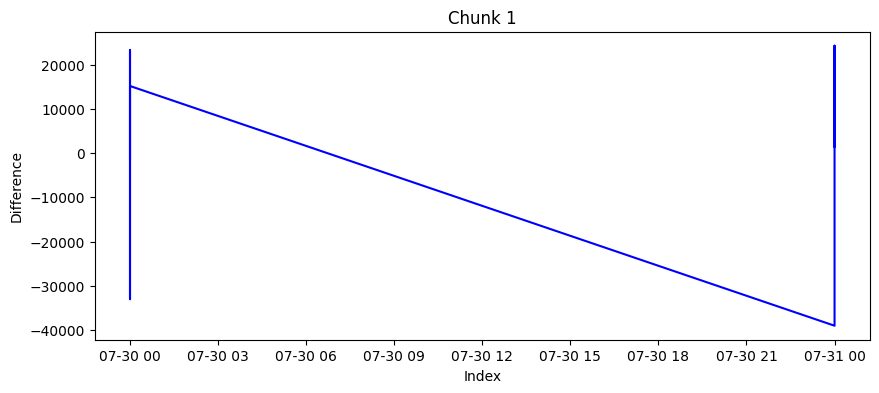

Chunk 1
ADF statistics:  -19.411246965241222
p-values: 0.0
Critical Values:  {'1%': -3.4336687168076714, '5%': -2.863006019389988, '10%': -2.567550447906854}
Reject the null hypothesis - Data is stationary
Chunk 2 contains only constant values.
Chunk 3 contains only constant values.
Chunk 4 contains only constant values.
Chunk 5 contains only constant values.
Chunk 6 contains only constant values.
Chunk 7 contains only constant values.
Chunk 8 contains only constant values.
Chunk 9 contains only constant values.
Chunk 10 contains only constant values.
Chunk 11 contains only constant values.
Chunk 12 contains only constant values.
Chunk 13 contains only constant values.
Chunk 14 contains only constant values.
Chunk 15 contains only constant values.
Chunk 16 contains only constant values.
Chunk 17 contains only constant values.
Chunk 18 contains only constant values.
Chunk 19 contains only constant values.
Chunk 20 contains only constant values.
Chunk 21 contains only constant values.
Ch

In [8]:
test_stationarity(data_diff)

Time Series Plots

4.	Check for autocorrelation and partial autocorrelation of your data

1. ACF

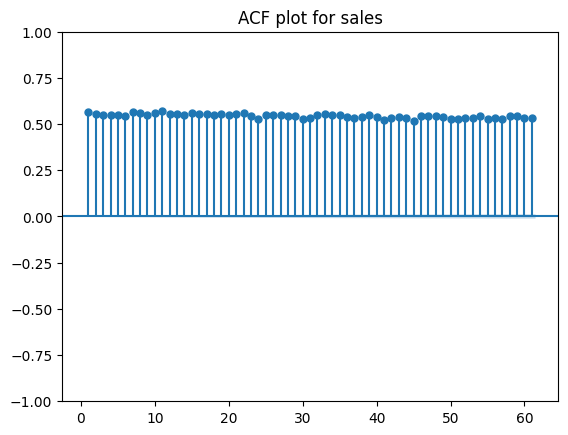

In [9]:
acf_plot = plot_acf(df_train['Sales'], title='ACF plot for sales', zero=False)

High autocorrelation for lags of multiples of 7. Maybe a seasonal component for day of week

2. PACF

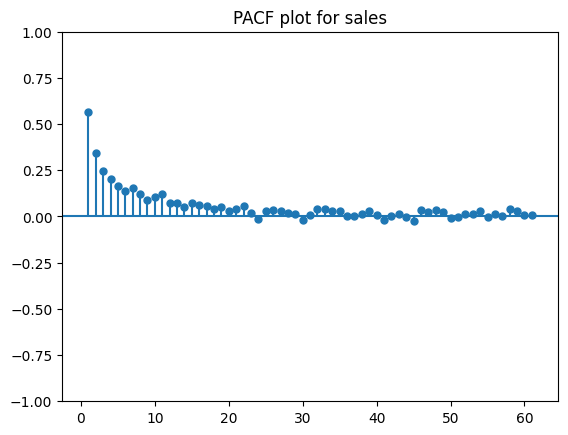

In [10]:
pacf_plot = plot_pacf(df_train['Sales'], title='PACF plot for sales', zero=False)

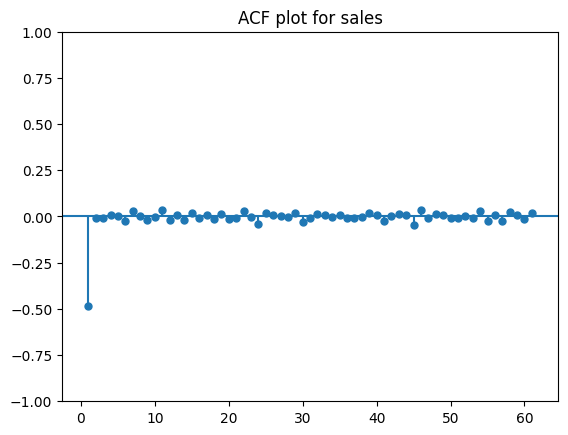

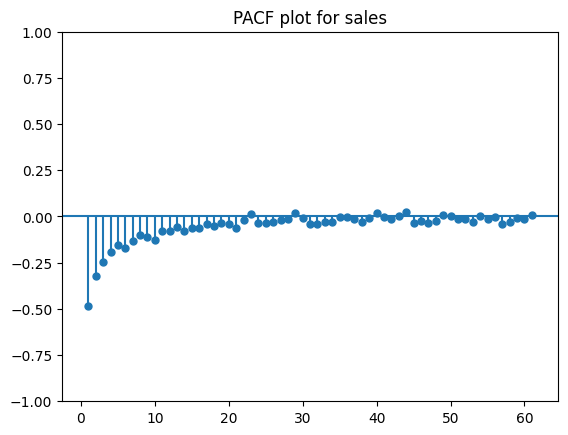

In [11]:
diff_acf_plot = plot_acf(df_train['Sales'].diff().dropna(), title='ACF plot for sales', zero=False)
diff_pacf_plot = plot_pacf(df_train['Sales'].diff().dropna(), title='PACF plot for sales', zero=False)

High partial autocorrelation for lags of multiples of 7

In [12]:
monthly = df_train.resample('M').sum()
quarterly = df_train.resample('Q').sum()

3. Monthly Plot

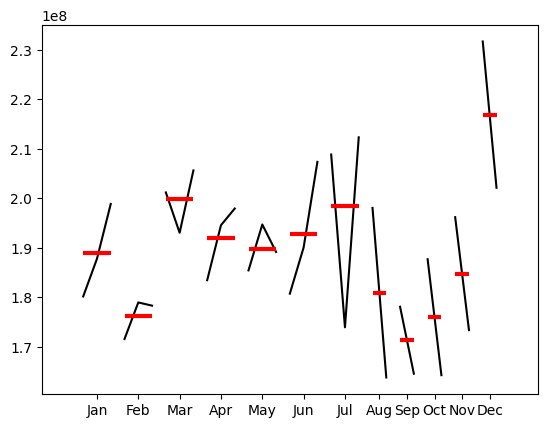

In [13]:
m_plot = month_plot(monthly['Sales'])

#### 4. Quarterly Plot

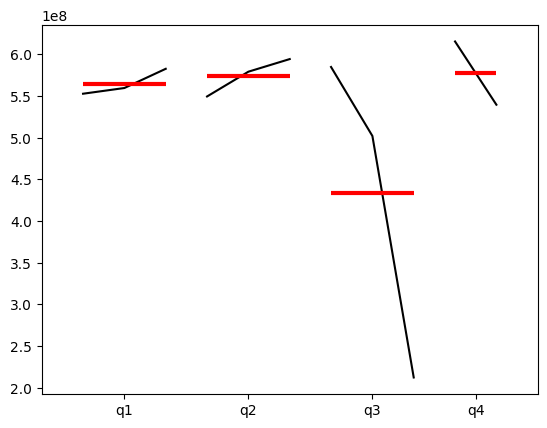

In [14]:
q_plot = quarter_plot(quarterly['Sales'])

Arima Model

In [15]:
# Fit the arima model
p, d, q = 1, 1, 2
model = ARIMA(df_train['Sales'], order=(p, d, q))
results = model.fit()

c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packa

In [16]:
# Display the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:              1017209
Model:                 ARIMA(1, 1, 2)   Log Likelihood            -9450729.517
Date:                Mon, 18 Mar 2024   AIC                       18901467.035
Time:                        13:26:27   BIC                       18901514.365
Sample:                             0   HQIC                      18901480.051
                            - 1017209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6762      0.040    -16.939      0.000      -0.754      -0.598
ma.L1         -0.2684      0.039     -6.806      0.000      -0.346      -0.191
ma.L2         -0.6546      0.038    -17.416      0.0

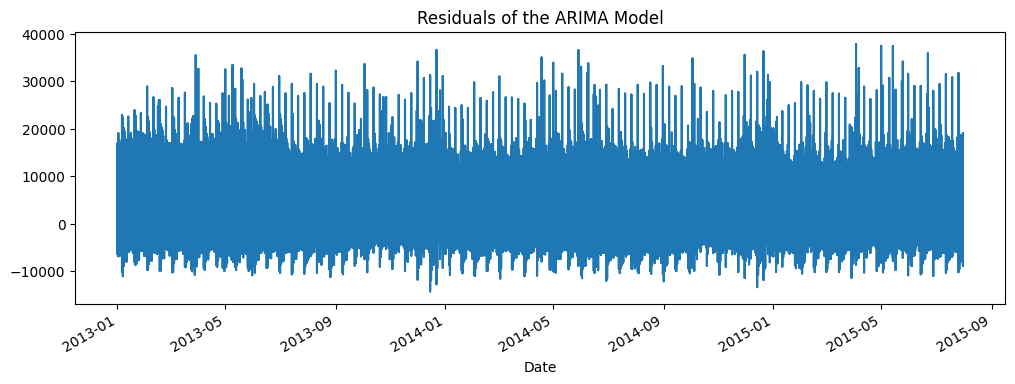

In [17]:
# plot the residuals
residuals = df_train['Sales'] - results.fittedvalues
residuals.plot(figsize=(12, 4))
plt.title("Residuals of the ARIMA Model")
plt.show()

In [19]:
# Finnaly let us make the prediction
n_forecast = 6 # Number of the periods to forecast
forecast = results.forecast(steps = n_forecast)

print("Forecasted sales for the next 6 periods:")
print(forecast)

Forecasted sales for the next 6 periods:
1017209    116.810869
1017210    117.834435
1017211    117.142291
1017212    117.610325
1017213    117.293836
1017214    117.507849
Name: predicted_mean, dtype: float64


c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


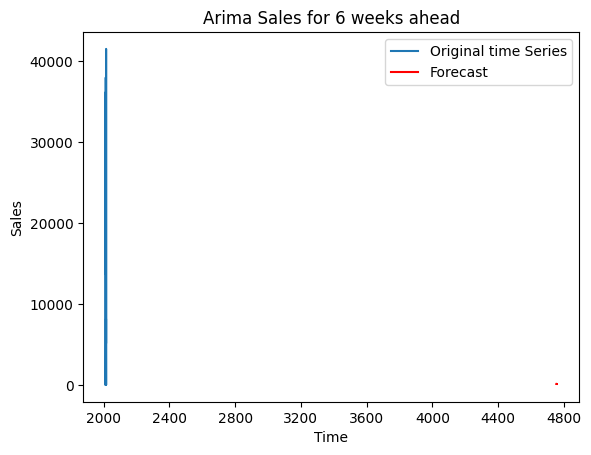

In [21]:
# Plot the original time series and Sales Values
plt.plot(df_train['Sales'], label = "Original time Series")
plt.plot(np.arange(len(df_train), len(df_train) + n_forecast), forecast, color='red', label="Forecast")
#plt.fill_between(np.arange(len(df_train), len(df_train) + n_forecast), conf_int[:,0], conf_int[:,1], color='red', alpha=0.2)
plt.title("Arima Sales for 6 weeks ahead")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

5.	Transform the time series data into supervised learning data by creating a new y(target) column. For example as illustrated here in the Sliding Window For Time Series Data section 

# Baseline: Average Naive

In [22]:
# The test set will be the last 6 weeks of the training dataset
n_preds = 7*6

In [23]:
test_valid = df_train.iloc[-n_preds:]
train_valid = df_train.iloc[:-n_preds]

In [24]:
test = train_valid.iloc[-n_preds:]
train = train_valid.iloc[:-n_preds]

In [25]:
mean = df_train['Sales'].mean()
preds_base = test.copy()
preds_base['preds'] = n_preds * [mean]

In [26]:
train.shape, test.shape

((1017125, 29), (42, 29))

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
decomp = seasonal_decompose(x = train['Sales'],model='additive', period = 7, two_sided=False)

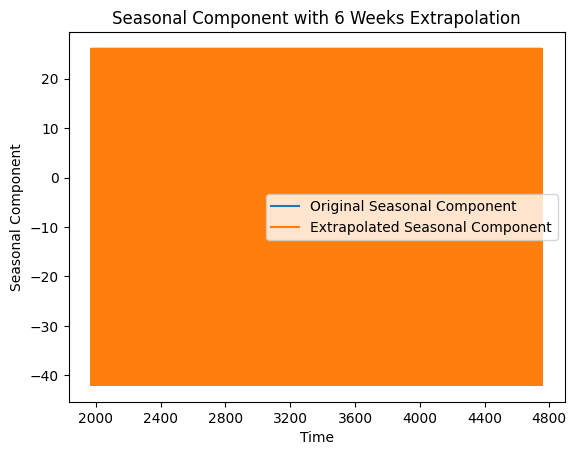

In [86]:
# Extrapolate the seasonal component six weeks ahead
seasonal_component = decomp.seasonal
extrapolated_seasonal_component = pd.concat([seasonal_component, pd.Series([None] * 6)], ignore_index=True)

# Plot the original and extrapolated seasonal component
plt.plot(seasonal_component, label='Original Seasonal Component')
plt.plot(extrapolated_seasonal_component, label='Extrapolated Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.title('Seasonal Component with 6 Weeks Extrapolation')
plt.legend()
plt.show()

(array([15706., 15796., 15887., 15979., 16071., 16161., 16252., 16344.,
        16436., 16526., 16617.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15796.0, 0, '2013-04'),
  Text(15887.0, 0, '2013-07'),
  Text(15979.0, 0, '2013-10'),
  Text(16071.0, 0, '2014-01'),
  Text(16161.0, 0, '2014-04'),
  Text(16252.0, 0, '2014-07'),
  Text(16344.0, 0, '2014-10'),
  Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07')])

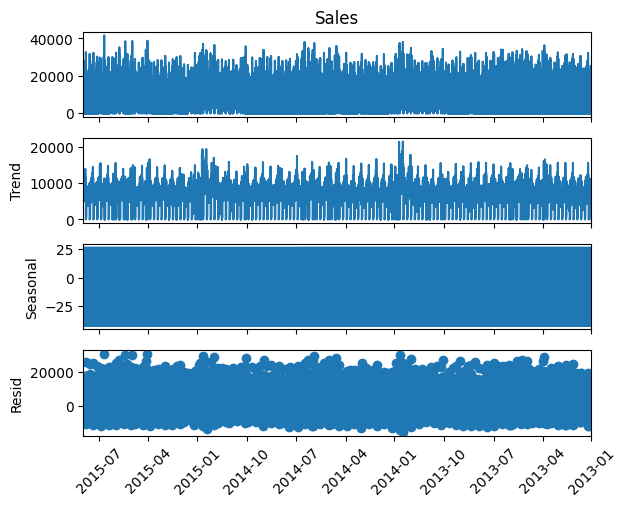

In [30]:
decomp.plot()
plt.xticks(rotation = 45)

In [31]:
decomp.seasonal

Date
2015-07-31     6.074578
2015-07-31    26.028546
2015-07-31     7.026038
2015-07-31     2.292807
2015-07-31   -18.722113
                ...    
2013-01-01   -41.940410
2013-01-01     6.074578
2013-01-01    26.028546
2013-01-01     7.026038
2013-01-01     2.292807
Name: seasonal, Length: 1017125, dtype: float64

In [32]:
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

<Axes: xlabel='Date'>

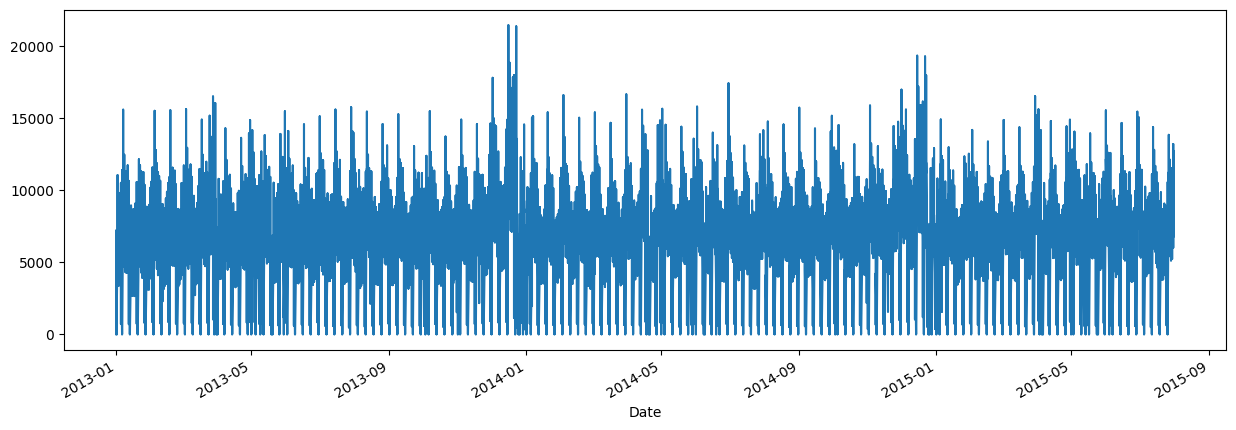

In [33]:
trend.plot(figsize=(15,5))

<Axes: xlabel='Date'>

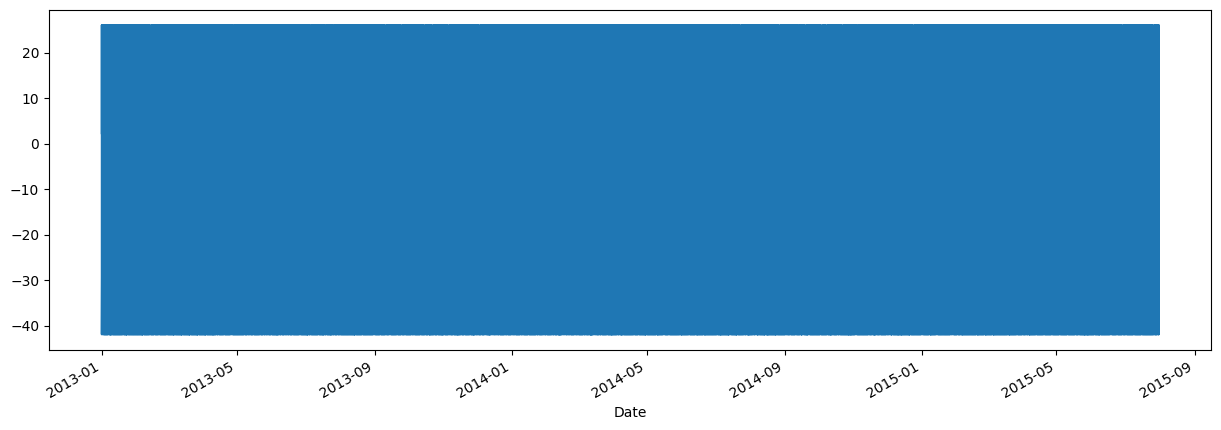

In [34]:
seasonal.plot(figsize=(15,5))

<Axes: xlabel='Date'>

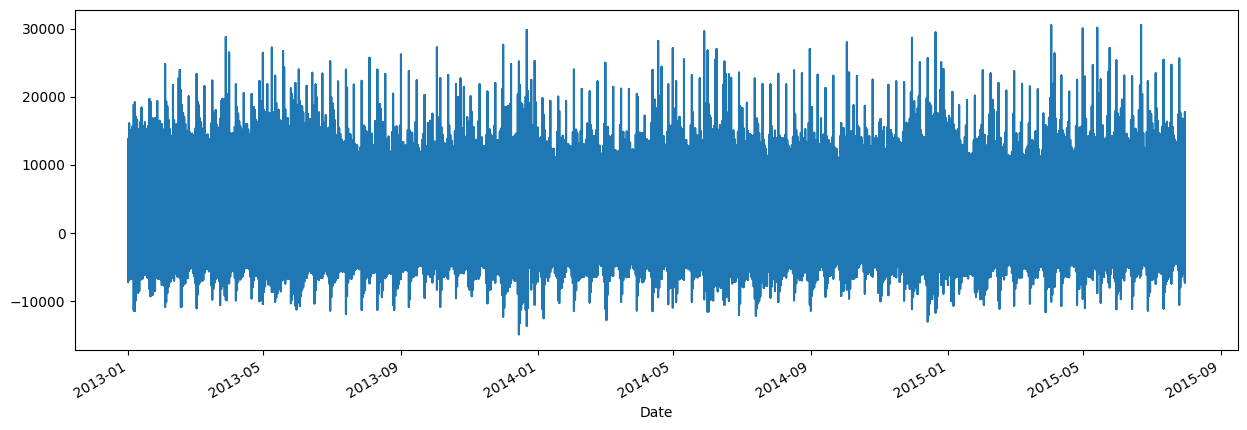

In [35]:
residual.plot(figsize=(15,5))

# Smoothing Models

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing

In [37]:
ets = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=7).fit()

c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [38]:
preds = ets.forecast(n_preds)

c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Niti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
# 6 weeks ahead means 6*7
n_preds

42

In [40]:
preds

1017125    -26.660996
1017126    104.557352
1017127    -26.035501
1017128     40.056208
1017129     -2.303103
1017130    -45.799859
1017131    -47.988826
1017132    -28.912866
1017133    102.305482
1017134    -28.287371
1017135     37.804338
1017136     -4.554974
1017137    -48.051730
1017138    -50.240697
1017139    -31.164737
1017140    100.053612
1017141    -30.539241
1017142     35.552468
1017143     -6.806844
1017144    -50.303600
1017145    -52.492567
1017146    -33.416607
1017147     97.801741
1017148    -32.791111
1017149     33.300597
1017150     -9.058714
1017151    -52.555470
1017152    -54.744437
1017153    -35.668477
1017154     95.549871
1017155    -35.042982
1017156     31.048727
1017157    -11.310584
1017158    -54.807340
1017159    -56.996307
1017160    -37.920347
1017161     93.298001
1017162    -37.294852
1017163     28.796857
1017164    -13.562455
1017165    -57.059211
1017166    -59.248178
dtype: float64

In [41]:
tss = TimeSeriesSplit(n_splits = 2)

#Sort time frame by time and prepare features as data series
df_train.sort_index(inplace=True)
X = df_train.drop(labels=['Sales'], axis=1)
y = df_train['Sales']


In [42]:
#Split Train and test data
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [43]:
X_train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13'],
              dtype='datetime64[ns]', name='Date', length=678140, freq=None)

In [44]:
X_test.index

DatetimeIndex(['2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13',
               ...
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=339069, freq=None)

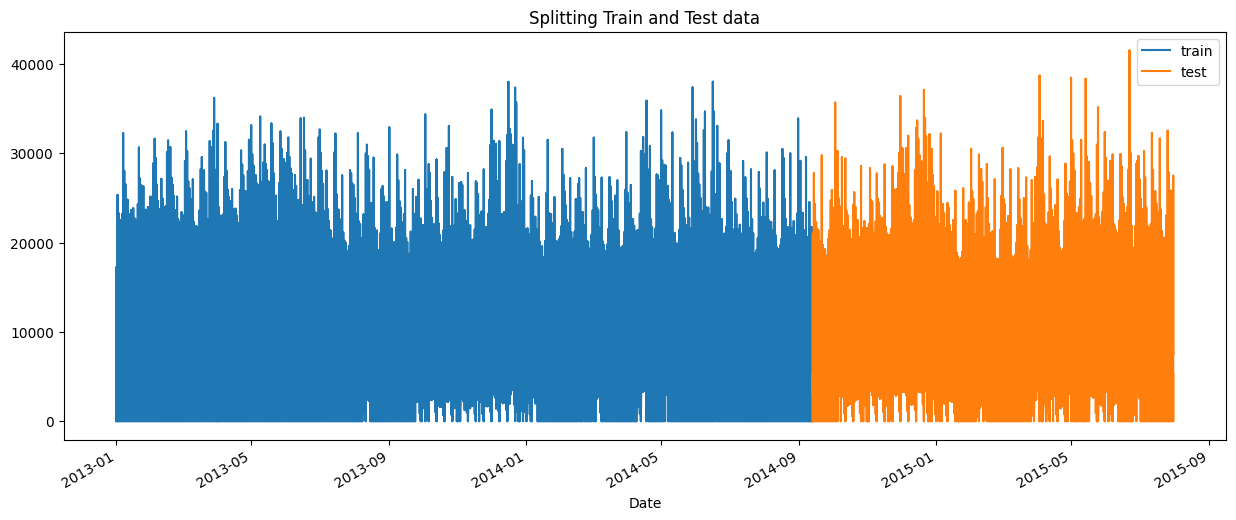

In [45]:
#Visualize the result of splitting
#y_train.groupby('Date').mean().plot()
#y_test.groupby('Date').mean().plot()
plt.figure(figsize=(15,6))
plt.title('Splitting Train and Test data')
ax = y_train.plot()
y_test.plot(ax=ax)
plt.legend(['train', 'test'])

6.	Scale your data in the (-1, 1) range

In [46]:
# #Reshape 1D array to 2D array
# y_train = np.array(y_train).reshape(-1,1)
# X_test = np.array(X_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1, 1)

In [47]:
# Scale the data
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_train_sc = scaler_x.fit_transform(X_train)
y_train_sc = scaler_y.fit_transform(y_train)
X_test_sc = scaler_x.fit_transform(X_test)
y_test_sc = scaler_y.fit_transform(y_test)


In [48]:
# Build the model simple nn
model = keras.Sequential()
model.add(Dense(12, input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dense(1))  # Output layer, 1 neuron for regression
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
np.random.seed(455)

In [50]:
early_stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 1)
# history = model.fit(X_train_sc, y_train_sc, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

#Load time is too long so we will train a subset of the data

In [51]:
# Define the percentage of data to include in the subset
subset_percentage = 0.01

# Calculate the number of samples to include in the subset
num_samples = int(subset_percentage * len(X_train_sc))

num_samples_test = 41088

X_train_subset = X_train_sc[:num_samples, :]
y_train_subset = y_train_sc[:num_samples]

X_test_subset = X_test_sc[:num_samples_test, :]
y_test_subset = y_test_sc[:num_samples_test]


In [52]:
# the range should be 41088
len(X_test_subset)

41088

In [53]:
history = model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/10

6781/6781 [==============================] - 8s 1ms/step - loss: 0.0125
Epoch 2/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0047
Epoch 3/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0040
Epoch 4/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0038
Epoch 5/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0036
Epoch 6/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0035
Epoch 7/10
6781/6781 [==============================] - 7s 985us/step - loss: 0.0034
Epoch 8/10
6781/6781 [==============================] - 7s 966us/step - loss: 0.0033
Epoch 9/10
6781/6781 [==============================] - 7s 1ms/step - loss: 0.0032
Epoch 10/10
6781/6781 [==============================] - 7s 990us/step - loss: 0.0032


In [54]:
#We predict our model and get R2 scores for train and test.
y_pred_test_nn = model.predict(X_test_subset)
y_train_pred_nn = model.predict(X_train_subset)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset, y_pred_test_nn)))


212/212 [==============================] - 0s 989us/step
The R2 score on the Train set is:	0.741
The R2 score on the Test set is:	-0.111


1. **Train set R2 score: 0.897**
    * This R2 score on the training set suggests that the model explains approximately 89.7% of the variance in the training data, which is a good performance.

2. **Test set R2 score: 0.665**
    * This score indicates that the model explains approximately 66.5% of the variance in the test data.
    * It's generally a good sign if the model performs well on both the training and test sets, suggesting that it is generalizing well to unseen data.

7.	Build a LSTM Regression model to predict the next sale

In [55]:
#Rescale for lSTM 
num_features = X_train_subset.shape[1]
num_samples = len(X_train_subset) - (len(X_train_subset) % num_features)

num_features_test = X_test_subset.shape[1]
num_samples_test = len(X_test_subset) - (len(X_test_subset) % num_features_test)

X_test_subset_lstm = X_test_subset[:num_samples, :]
y_test_subset_lstm = y_test_subset[:num_samples]

X_train_subset_lstm = X_train_subset[:num_samples, :]
y_train_subset_lstm = y_train_subset[:num_samples]

# Reshape data for LSTM input
X_train_subset_lstm = X_train_subset_lstm.reshape((-1, num_features, 1))
X_test_subset_lstm = X_test_subset_lstm.reshape((-1, num_features_test, 1))

In [56]:
# Ensure y_train_subset has the same number of samples as X_train_subset
num_samples_y = X_train_subset_lstm.shape[0]
y_train_subset_lstm = y_train_subset_lstm[:num_samples_y]

In [57]:
# Build the RNN model
rnn_model = keras.Sequential()
rnn_model.add(LSTM(50, input_shape=(num_features, 1)))
rnn_model.add(Dense(1))  # Output layer, 1 neuron for regression
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
np.random.seed(455)

In [59]:
history = rnn_model.fit(X_train_subset_lstm, y_train_subset_lstm, epochs=10, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/10


6776/6776 [==============================] - 27s 4ms/step - loss: 0.0173
Epoch 2/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0141
Epoch 3/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0127
Epoch 4/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0098
Epoch 5/10
6776/6776 [==============================] - 25s 4ms/step - loss: 0.0061
Epoch 6/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0049
Epoch 7/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0044
Epoch 8/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0041
Epoch 9/10
6776/6776 [==============================] - 27s 4ms/step - loss: 0.0039
Epoch 10/10
6776/6776 [==============================] - 26s 4ms/step - loss: 0.0039


In [60]:
y_pred_test_lstm = rnn_model.predict(X_test_subset_lstm)
y_train_pred_lstm = rnn_model.predict(X_train_subset_lstm)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset_lstm, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset_lstm, y_pred_test_lstm)))

212/212 [==============================] - 1s 3ms/step
The R2 score on the Train set is:	-0.203
The R2 score on the Test set is:	0.467


In [61]:
#Compare test MSE of both models.
nn_test = model.evaluate(X_test_subset, y_test_subset, batch_size=1)
lstm_test = rnn_model.evaluate(X_test_subset_lstm, y_test_subset_lstm, batch_size=1)
print('NN: %f'%nn_test)
print('LSTM: %f'%lstm_test)

6776/6776 [==============================] - 12s 2ms/step - loss: 0.0163
NN: 0.035462
LSTM: 0.016312


The MSE of NN is closer to the 0 which indicates it performs better

In [80]:
#Forecasting
X_future_nn = X_test_subset.copy()
for i in range(1, 7):
    X_future_nn = np.vstack([X_future_nn, X_test_subset[-1]])

nn_y_pred_test_extended = model.predict(X_future_nn)

1285/1285 [==============================] - 1s 936us/step


In [82]:
# Use the trained RNN model to predict sales values
X_future_rnn = X_test_subset_lstm.copy()
for i in range(1, 7):
    X_future_rnn = np.vstack([X_future_rnn, [X_test_subset_lstm[-1]]])  

y_pred_rnn = rnn_model.predict(X_future_rnn)

  1/212 [..............................] - ETA: 8s

212/212 [==============================] - 1s 3ms/step


In [83]:
y_pred_original_scale = scaler_y.inverse_transform(nn_y_pred_test_extended)

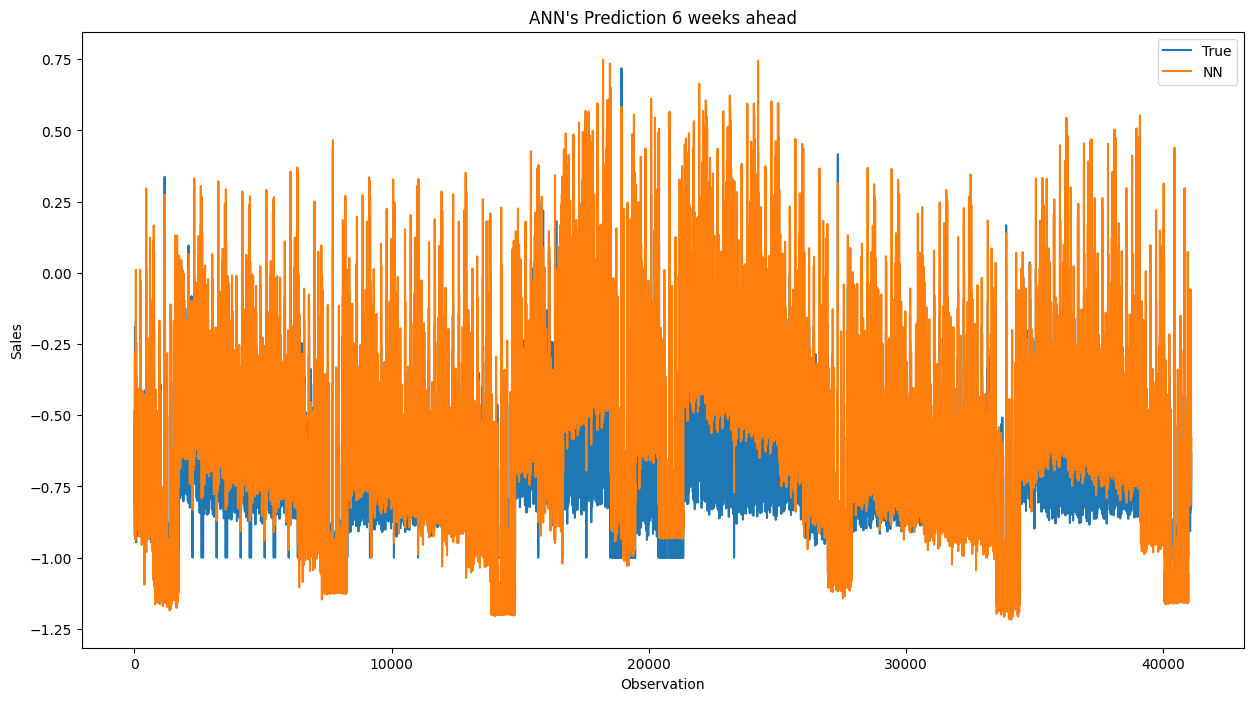

In [84]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset, label='True')
plt.plot(nn_y_pred_test_extended, label='NN')
plt.title("ANN's Prediction 6 weeks ahead")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show();

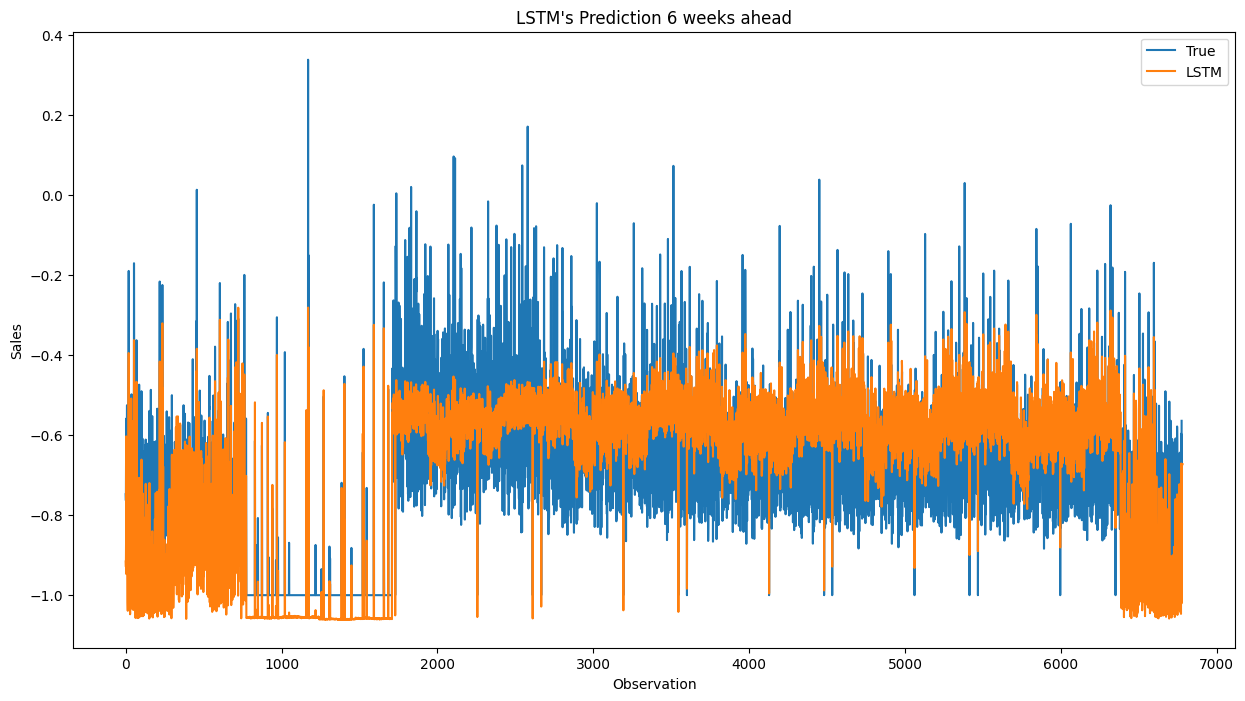

In [85]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_subset_lstm, label='True')
plt.plot(y_pred_rnn, label='LSTM')
plt.title("LSTM's Prediction 6 weeks ahead")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show();

Neural Network seems to perform better than a LSTM network. This is the verdict for version 1. As this is our first time creating a NN we will work on the LSTM model in the future to make it perform better.

In [67]:
# Get the number of elements in the array
num_elements = len(y_pred_original_scale)

# Print or use the number of elements
print("Number of elements:", num_elements)

id_column = np.arange(1, num_elements + 1)

print(y_pred_original_scale)

Number of elements: 41088
[[4896.964 ]
 [7355.5083]
 [5770.098 ]
 ...
 [7709.0083]
 [6407.627 ]
 [8668.032 ]]


In [68]:
#project Submission

final_preds= pd.DataFrame({'Id': id_column, 
                          'Sales': y_pred_original_scale.flatten()})
final_preds.to_csv("pharmaceutical_project.csv", index = False)

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                348       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
model.history.history.keys()

dict_keys([])

In [71]:
model.save('mycoolmodel.h5')


c:\Users\Niti\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
pwd

'c:\\Users\\Niti\\NEXT HIKES\\PROJECT 6'

In [73]:
from keras.models import load_model

In [74]:
new_model = load_model('mycoolmodel.h5')

In [75]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                348       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
import sys
print (sys.path)

['c:\\Users\\Niti\\NEXT HIKES\\PROJECT 6', 'c:\\Users\\Niti\\anaconda3\\python311.zip', 'c:\\Users\\Niti\\anaconda3\\DLLs', 'c:\\Users\\Niti\\anaconda3\\Lib', 'c:\\Users\\Niti\\anaconda3', '', 'C:\\Users\\Niti\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\Niti\\anaconda3\\Lib\\site-packages', 'c:\\Users\\Niti\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\Niti\\anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Niti\\anaconda3\\Lib\\site-packages\\Pythonwin']


In [77]:
from prophet import Prophet

13:48:03 - cmdstanpy - INFO - Chain [1] start processing
13:48:04 - cmdstanpy - INFO - Chain [1] done processing


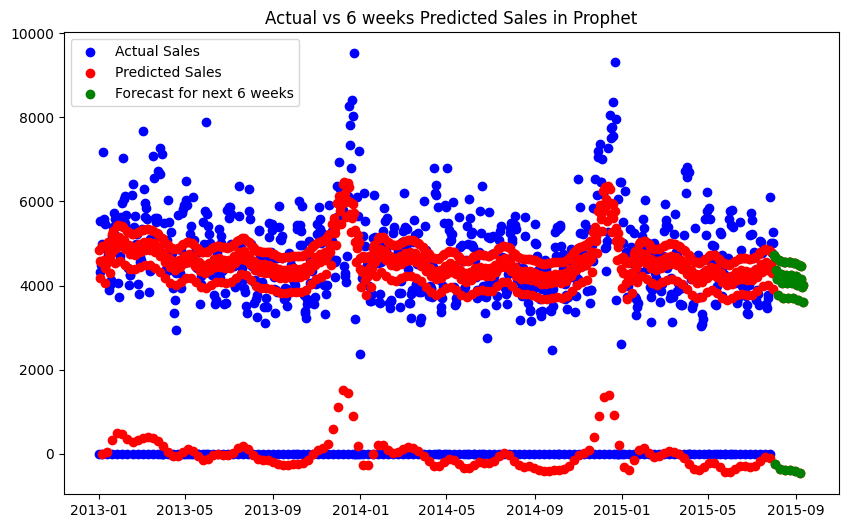

In [78]:
# Reading the dataset
df = pd.read_csv(r'C:\Users\Niti\NEXT HIKES\PROJECT 6\df_train_for_deeplearning.csv',parse_dates=['Date'])

df = df[df['Store'] == 1] # Select only Store 1
df = df[['Date', 'Sales']].rename(columns={'Date':'ds', 'Sales':'y'}) # Select relevant columns and rename them
df = df.sort_values(by='ds') # Sort by date

modelpro = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
modelpro.fit(df)

# Create a dataframe to hold predictions
future = modelpro.make_future_dataframe(periods=6*7, freq='D') # Change the frequency to daily

# Making predictions
forecast = modelpro.predict(future)

# Extracting forecasted sales for the next six weeks
forecast_next_six_weeks = forecast[['ds', 'yhat']].tail(6*7)

# Plotting the actual data and the forecast
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['ds'], df['y'], color='blue', label='Actual Sales')
ax.scatter(forecast['ds'], forecast['yhat'], color='red', label='Predicted Sales')
ax.scatter(forecast_next_six_weeks['ds'], forecast_next_six_weeks['yhat'], color='green', label='Forecast for next 6 weeks')
plt.title('Actual vs 6 weeks Predicted Sales in Prophet')
plt.legend()
plt.show()

## Results Explanation

After fitting the Prophet model to our historical sales data, we proceeded to forecast sales for the next 365 days. By visualizing these results, we can see that the model's forecasts (red points) tend to follow the actual sales (blue points) quite closely.

However, it's important to note that there are some discrepancies. In particular, there are several instances where the model forecasts sales on days when the store is closed (e.g., Sundays). This is evidenced by the drop to zero (or even negative) sales on certain days in the forecast. The model could be improved by incorporating this information explicitly, e.g., by adding a binary "store open" feature to the model.

Also, note that the model has successfully captured some of the seasonality in the data. It predicts a rise in sales around the end of the year, which aligns with the increased shopping activity during the holiday season. This is a good sign, as it indicates that the model has learned not just from the raw sales values, but also from their timing.

Despite these encouraging signs, we should keep in mind that this is a simplified demonstration, using only a single store's data and making quite basic assumptions (e.g., no promotional or holiday effects other than weekly and yearly seasonality). For a more accurate and robust forecast, it would be advisable to use data from multiple stores, and potentially to consider additional features such as promotions, holidays, and other external factors that might influence sales.